Create dataset (video preprocessing, frame, optical flow, audio)

# Importing Dependencies

In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split

import os
import IPython.display as ipd
import constants as const
import cv2
import librosa
import librosa.display
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import progressbar as pb
import tensorflow as tf
import utils
import utils_flow as ut_fl
import utils_audio as ut_au

In [2]:
# Set the seed value for experiment reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
utils.system_info()


    Windows:
        Version: 10.0 build 19045
    Python:
        Version: 3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]
        Path: C:\Users\mic-c\anaconda3\envs\opencv_contrib_env\python.exe
    


In [4]:
utils.modules_info()


    OpenCV:
        Version: 4.9.0
    Tensorflow:
        Version: 2.10.1
    


In [5]:
log_file = Path(const.logs_path, 'debug.log')
logging.basicConfig(
    format='%(asctime)s %(message)s',
    filemode='a',
    filename=log_file,
    encoding='utf-8',
    level=logging.INFO,
    force=True
)

In [6]:
EMOTIONS_LABELS = const.EMOTIONS_LABELS
label_names = const.EMOTIONS_LABELS_SORTED
NUM_CLASSES = const.DATASET_NUM_CLASSES

JPEG_COMPRESSION_QUALITY = 95  # def=95

# Audio
SAMPLE_RATE = const.RAVDESS_SAMPLE_RATE
FFT_LENGTH = 255
HOP_LENGTH = 512  # number of samples per time-step in spectrogram
N_MELS = 64  # number of bins in spectrogram. Height of image
FRAME_LENGTH = 255  # number of time-steps. Width of image

## Dataset Creation

### Video Dataset - dataset_full.csv

### Video Dataset - dataset.csv

### Frame Dataset - dataset_extended.csv

In [ ]:
# df_extended = df_extended.drop(columns=['frames'])

## DataFrame Loading

In [7]:
df = pd.read_csv(Path(const.csv_path, 'dataset.csv'))

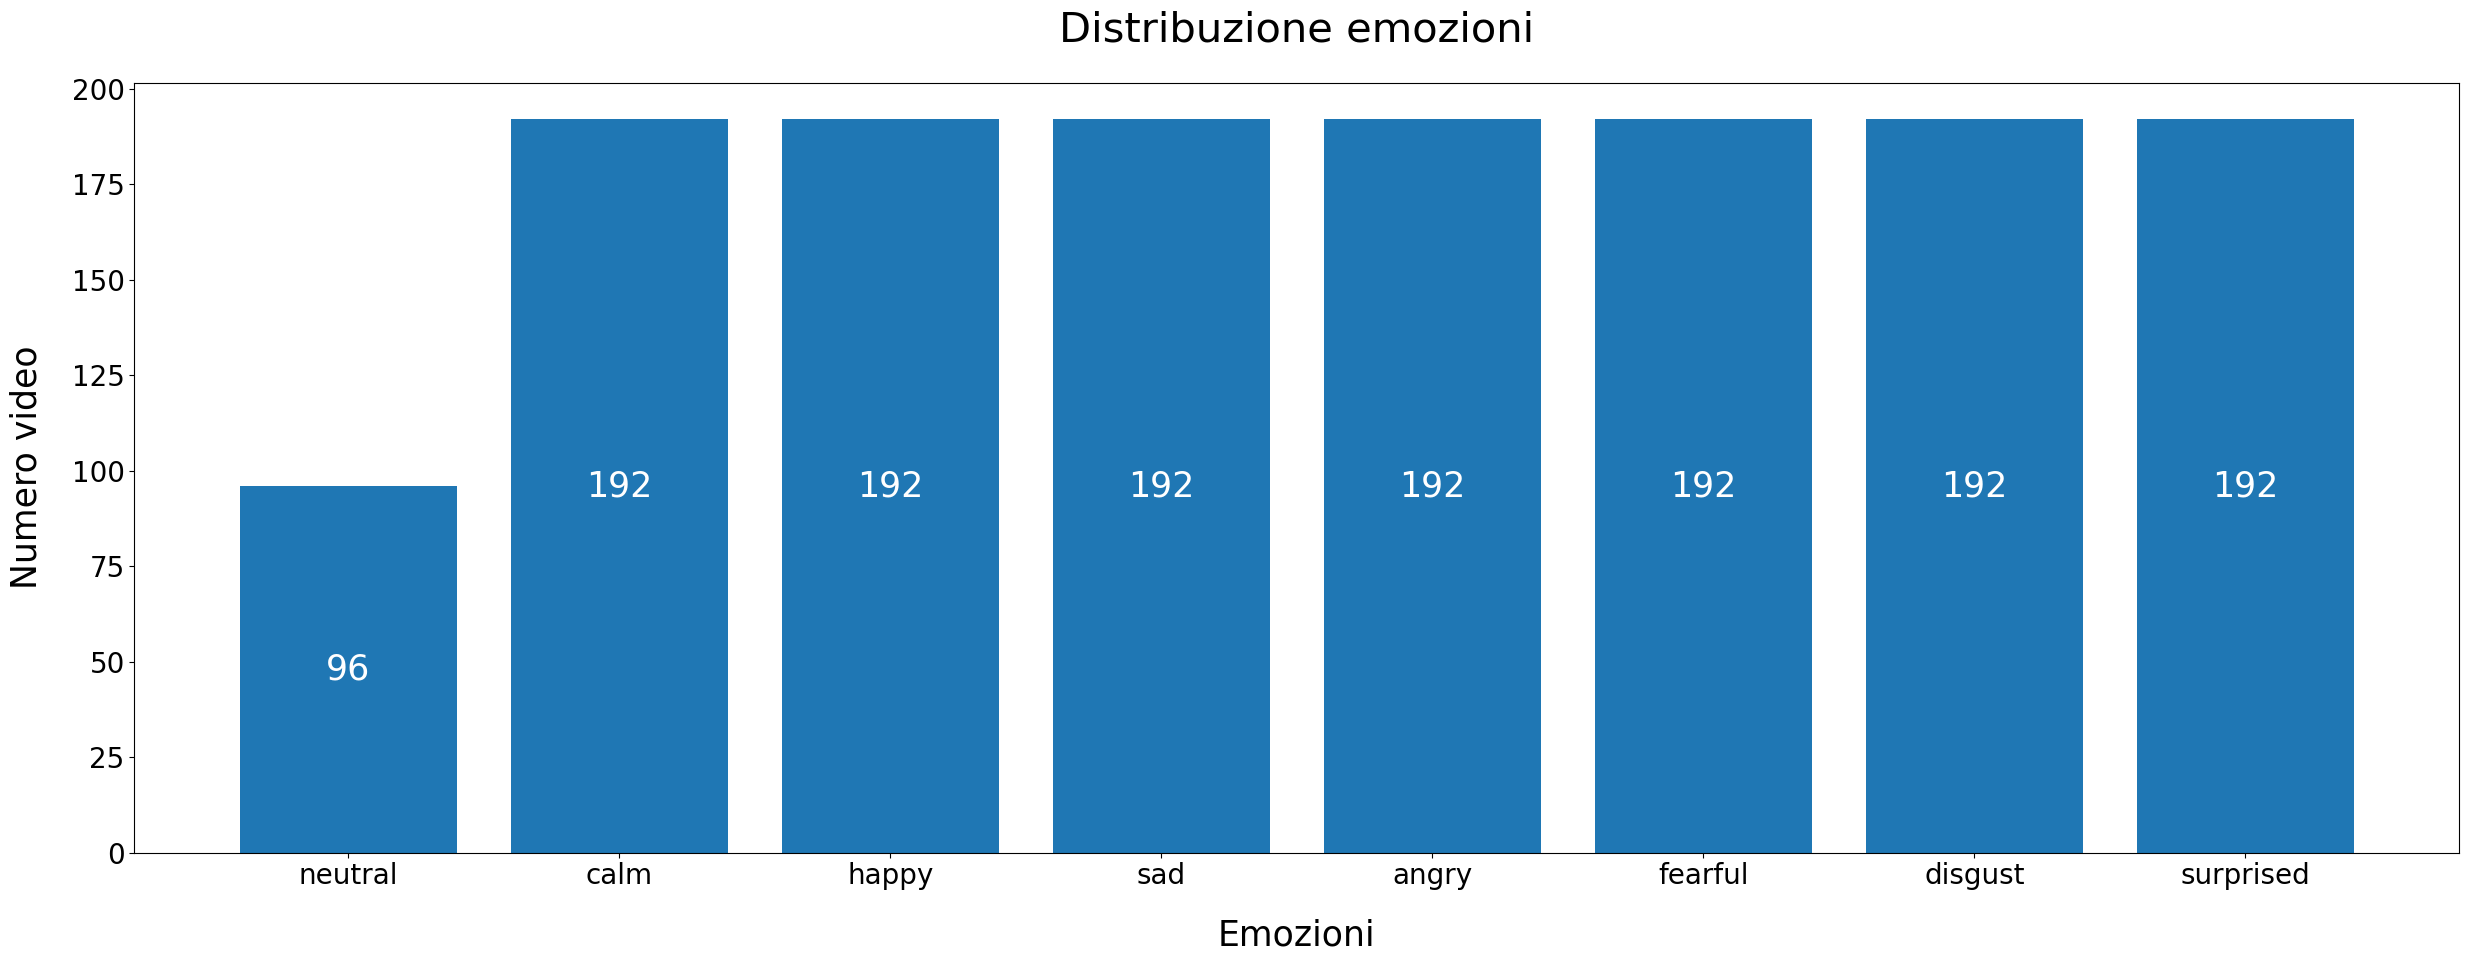

In [8]:
# Emotion distribution graph

fig = plt.figure(figsize=(30, 10))

x_mod = np.arange(1, 9)
y_mod = [
    len(df[df['emotion'] == EMOTIONS_LABELS]) for EMOTIONS_LABELS in x_mod
]

bar_plot = plt.bar(x_mod, y_mod)

plt.title('Distribuzione emozioni', fontsize=30, pad=30)
plt.ylabel('Numero video', fontsize=25, labelpad=20)
plt.xlabel('Emozioni', fontsize=25, labelpad=20)
plt.xticks(
    np.arange(1, len(x_mod) + 1),
    [EMOTIONS_LABELS[idx] for idx, x in enumerate(x_mod)],
    fontsize=20
)
plt.yticks(fontsize=20)

plt.bar_label(bar_plot, label_type='center', fontsize=25, color='white')

plt.show()


# Frame

In [13]:
# Dimensions of generated images

IMG_HEIGHT = IMG_WIDTH = const.MAX_HEIGHT

In [14]:
# MAX dimensions of bounding box

MAX_WIDTH = MAX_HEIGHT = const.MAX_WIDTH

In [15]:
# Human readable description of the considered dataset, for logging purposes

df_description = ''
df_description += 'fullAV'
df_description += ', speech'

### Video Dataset Refactoring

From the RAVDESS directory structure to structure based on emotions

### Frames Only

Si è considerato il database composto da video full-AV, e non cantati.
I frame sono stati salvati in Generated/Frames. Alla denominazione del video
originale, sono state aggiunte due nuove informazioni: la prima è il numero di 
frame del video, e la seconda è un flag (0/1) indicante se il frame facesse parte 
della parte centrale 'parlata' del video. Per delimitare tale parte, considerata più utile 
per il task, si è tagliata la parte iniziale e finale del video, i 2/3 di un secondo (30 fps).

#### Prima iterazione - OLD
Creazione solo cartelle emozioni

#### Seconda iterazione - OLD
Creazione cartelle emozioni contenenti una cartella per ogni attore, da cartelle già generate

#### Generazione corretta
Creazione cartelle emozioni contenenti una cartella per ogni attore

### Database Sampling

In [22]:
# Sample the database

sample_fraction = 1

if sample_fraction < 1:
    df_sampled, df_remaining = train_test_split(
        df, train_size=sample_fraction, random_state=SEED, stratify=df.emotion
    )
else:
    df_sampled = df

print(f'''Length of sample array is {len(df_sampled)} element,
{sample_fraction:.1%} of {len(df)}''')

Length of sample array is 1440 element,
100.0% of 1440


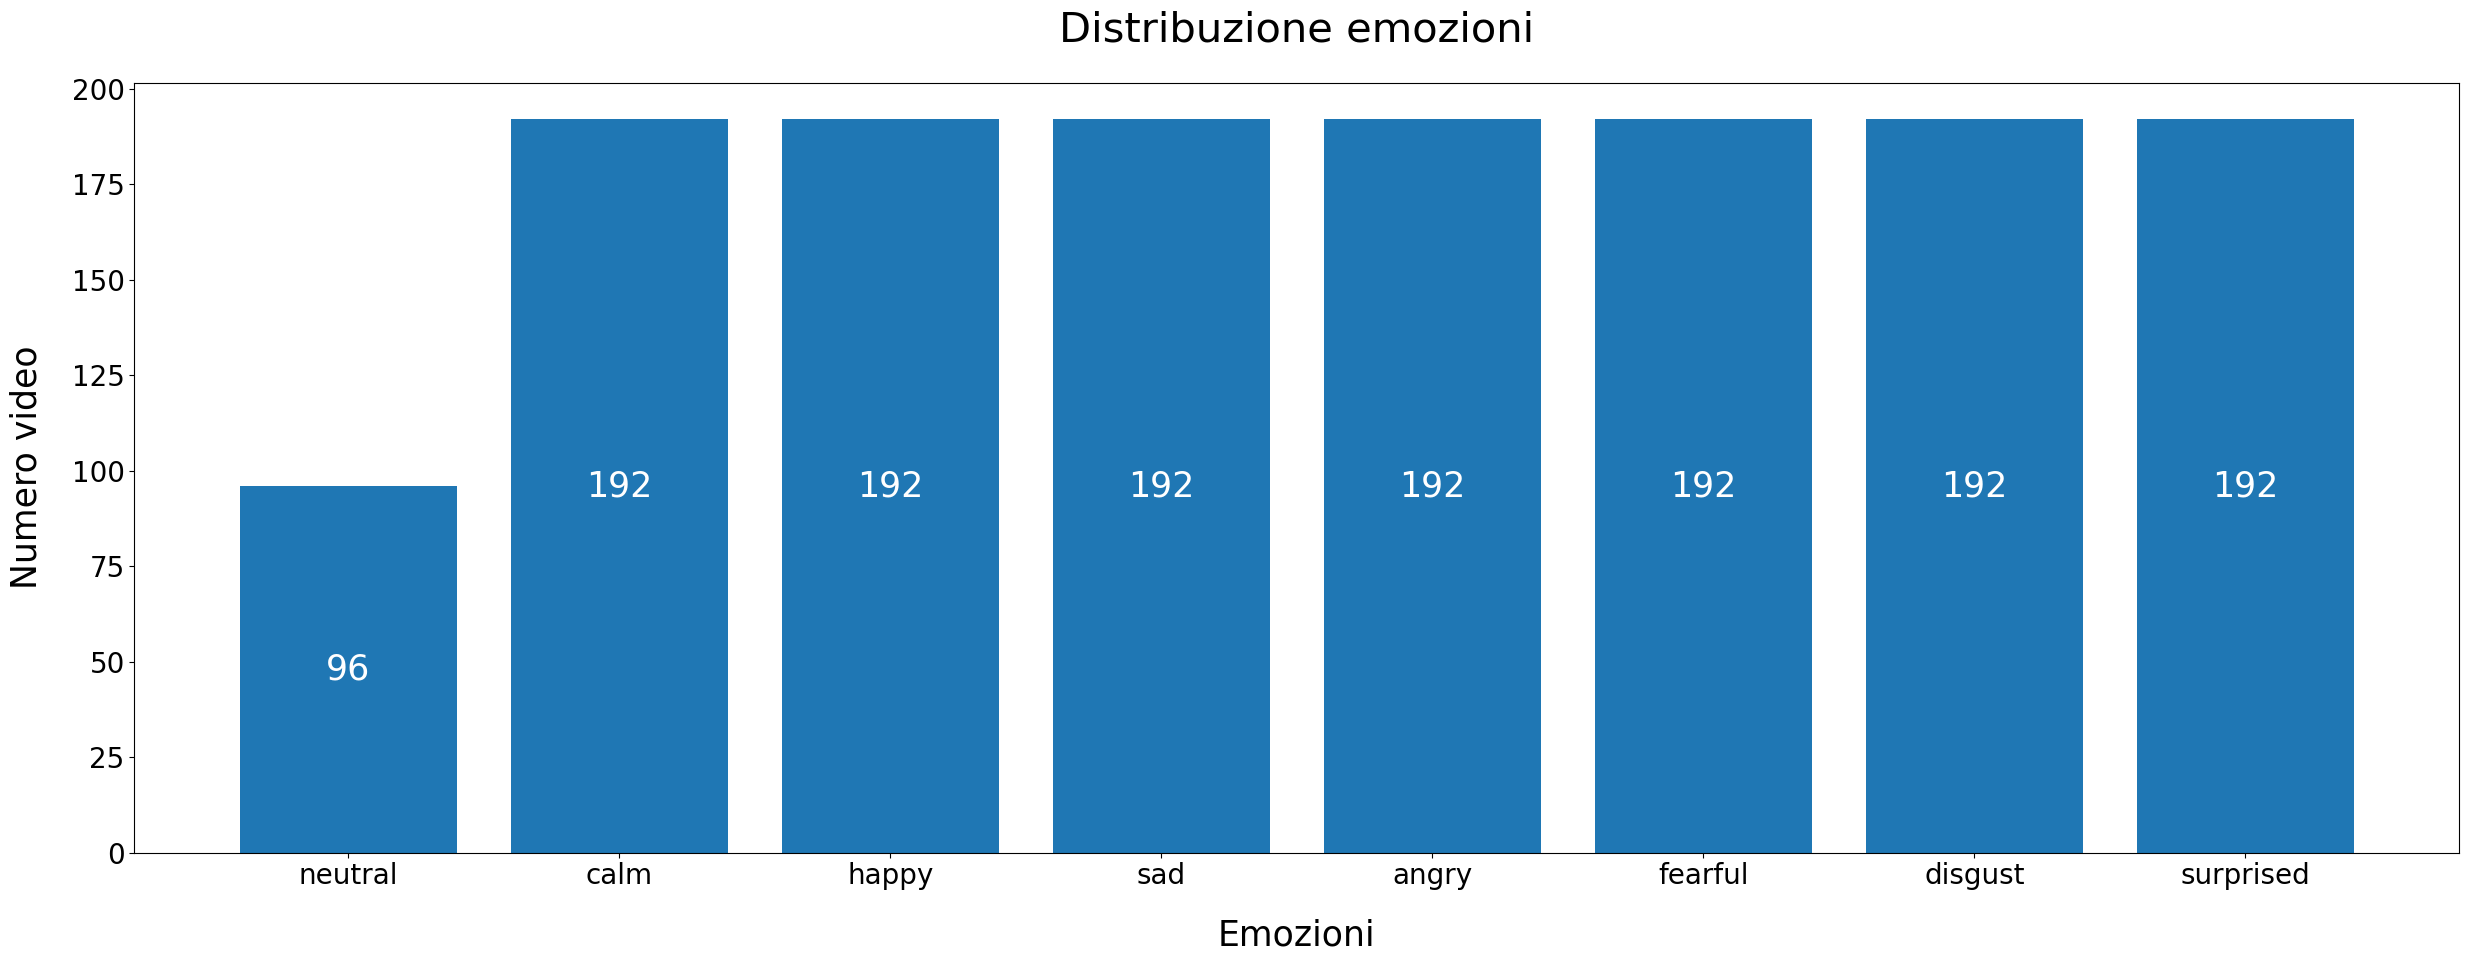

In [23]:
fig = plt.figure(figsize=(30, 10))

x_mod = np.arange(1, 9)
y_mod = [
    len(df_sampled[df_sampled['emotion'] == EMOTIONS_LABELS])
    for EMOTIONS_LABELS in x_mod
]

bar_plot = plt.bar(x_mod, y_mod)
plt.title('Distribuzione emozioni', fontsize=30, pad=30)
plt.ylabel('Numero video', fontsize=25, labelpad=20)
plt.xlabel('Emozioni', fontsize=25, labelpad=20)
plt.xticks(
    np.arange(1, len(x_mod) + 1),
    [EMOTIONS_LABELS[idx] for idx, x in enumerate(x_mod)],
    fontsize=20
)
plt.yticks(fontsize=20)

plt.bar_label(bar_plot, label_type='center', fontsize=25, color='white')
plt.show()

### Dataset with only relevant facial tracking info

### Dataset with lower/upper bound of speaking part - useful_frames.csv

## Generation of images

In [39]:
# Test Video
video = df_sampled.iloc[2]
ipd.Video(filename=str(Path(video.path, video.filename)), width=300)

-----------------------------------

### Frames and optic flow

In [24]:
# Farneback
p_0 = {
    'WINSIZE': 7,
    'PYR_SCALE': 0.8,
    'POLY_SIGMA': 1.7,
    'POLY_N': 30,
    'LEVELS': 30,
    'ITERATIONS': 3,
    'FLAGS': 0
}

In [25]:
# TVL1
p_1 = {
    'warps': 2,
    'useInitialFlow': False,
    'theta': 0.3,
    'tau': 0.25,
    'scaleStep': 0.8,
    'outerIterations': 3,
    'nscales': 3,
    'medianFiltering': 5,
    'lambda_': 0.15,
    'innerIterations': 3,
    'gamma': 0.0,
    'epsilon': 0.01
}

In [26]:
# PYFLOW
p_2 = {
    'pyflow_alpha': 0.012,
    'pyflow_ratio': 0.75,
    'pyflow_minWidth': 20,
    'pyflow_nOuterFPIterations': 7,
    'pyflow_nInnerFPIterations': 1,
    'pyflow_nSORIterations': 1,
    'pyflow_colType': 1
}

In [29]:
params_ar = [p_0, p_1, p_2]
funct_ar = [ut_fl.calc_flow_farneback, ut_fl.calc_flow_TVL1, ut_fl.calc_flow_pyflow]
funct_names_ar = ['Farneback', 'TVL1', 'Pyflow']

In [ ]:
save = True
test = True  # for choosing the right saving path
view = False  # True if you want to view images while generating
of_mode = 0  # 0: farneback, 1: TVL1, 2: Farneback

parameters = params_ar[of_mode]
of_function = funct_ar[of_mode]

total_elements = len(df_sampled)

p1 = pb.Progressbar('p1', elements=total_elements)
p2 = pb.Progressbar('p2', 100)

logging.info('Generating Frames + Flow')
logging.info(f'Dataset: {df_description}')
logging.info(f'Length of sample array is {len(df_sampled)} element,\
{sample_fraction:.1%} of {len(df)}')
logging.info(f'Image size: {IMG_WIDTH} x {IMG_HEIGHT}')

low_idx = np.rint(30 * (2 / 3))  # where 30=FPS

for index, row in df_sampled[:2].iterrows():

    p1.add_to_progress(1)

    # Extract video name
    path = row.path
    filename = row.filename

    target_class = utils.get_class_string(filename)

    full_path = Path(path, filename)
    video_name = utils.remove_extension(filename)
    actor = utils.get_actor(video_name)
    frame_save_path = const.test_frames_path if (test) else const.frames_path
    flows_save_path = const.test_flows_path if (test) else const.flows_path

    folder_frame_path = Path(frame_save_path, target_class, actor)
    folder_flow_path = Path(flows_save_path, funct_names_ar[of_mode], target_class, actor)

    if (save):
        folder_frame_path.mkdir(parents=True, exist_ok=True)
        folder_flow_path.mkdir(parents=True, exist_ok=True)

    csv_regex = f'{video_name}.csv'
    path_gen = Path(const.updated_landmarks_path).glob(csv_regex)

    ret_list = list(path_gen)

    try:
        video_csv = ret_list.pop(0)
    except IndexError:
        print(f'ERROR: Skipping video {full_path}: no ({csv_regex}) file')
        continue


    data = pd.read_csv(video_csv)

    vidcap = cv2.VideoCapture(str(full_path))

    frames = utils.get_video_frames(vidcap)

    p2.set_elements(frames)
    p2.add_to_progress(1)

    fps = utils.get_video_fps(vidcap)

    high_idx = frames - low_idx

    trim_frame = high_idx - low_idx

    seconds = frames / fps

    logging.info(f'Duration: {seconds:.2f}')
    logging.info(f'Speaking Frames: {trim_frame}\
        ({low_idx} - {high_idx}) = {(trim_frame/frames):.2%} of {frames}')
    logging.info('\n')


    frame_number = 1

    speaking_frame = frame_number >= low_idx and frame_number <= high_idx

    flow_string = f'{video_name}-{frame_number:03d}'
    speaking_string = '01' if speaking_frame else '00'

    save_string = f'{flow_string}-{speaking_string}.jpg'


    ret, frame1 = vidcap.read()

    ra = utils.calc_bounding_box(data, 1)

    x, y, width, height = ra['box']

    face = frame1[y:y + height, x:x + width, :]

    face = cv2.resize(face, dsize=(MAX_WIDTH, MAX_HEIGHT))

    # if (face.size and save):
    #     face_res = cv2.resize(face, dsize=(IMG_HEIGHT, IMG_WIDTH))
    #     cv2.imwrite(str(Path(folder_frame_path, save_string)), face_res)

    prvs_rgb = face
    prvs = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

    hsv = np.zeros_like(face)
    hsv[..., 1] = 255
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, 1)


    for frame_number in range(1, frames):

        ret, frame2 = vidcap.read()

        if not ret:
            if (frame_number < (frames-1)):
                print(f'''No frames grabbed!
                video: {full_path}
                frame: {frame_number}''')
            break

        p2.add_to_progress(1)
        speaking_frame = frame_number >= low_idx and frame_number <= high_idx

        flow_string = f'{video_name}-{frame_number:03d}'
        speaking_string = '01' if speaking_frame else '00'

        save_string = f'{flow_string}-{speaking_string}.jpg'
        optical_string = f'flow_{int(frame_number - (low_idx)):03d}.jpg'
        frame_string = f'frame_{int(frame_number - (low_idx - 1)):03d}.jpg'

        ra = utils.calc_bounding_box(data, frame_number)

        x, y, width, height = ra['box']

        face = frame2[y:y + height, x:x + width, :]

        face = cv2.resize(face, dsize=(MAX_WIDTH, MAX_HEIGHT))

        # if (face.size and save):
        #     face_res = cv2.resize(face, dsize=(IMG_HEIGHT, IMG_WIDTH))
        #     cv2.imwrite(str(Path(folder_frame_path, save_string)), face_res)

        next_rgb = face
        next = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

        gr1 = of_function(prvs, next, parameters)
        prvs = next
        if (save):
            gr1_res = cv2.resize(gr1, dsize=(IMG_HEIGHT, IMG_WIDTH))
            cv2.imwrite(str(Path(folder_flow_path, save_string)), gr1_res)

        if (view):
            # cv2.imshow('Vector Flow', ut_fl.draw_flow(next, flow))
            cv2.imshow('Video', face)
            # cv2.imshow('BGR Flow', bgr)
            cv2.imshow('GR1 BGRTOGRAY', gr1)
            # cv2.imshow('GR2 SPLIT', gr2)

            k = cv2.waitKey(30) & 0xff
            if k == 27:
                break

    vidcap.release()
    cv2.destroyAllWindows()

    p2.update_progress(frames)

p1.update_progress(total_elements)

'Progress: [--------------------] 0%             1/1440'

'Progress: [########------------] 40%             42/99'

In [41]:
logging.shutdown()

-------------------------------------------------------------